In [1]:
import sys
sys.path.insert(1, '../')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm
from skmisc.loess import loess
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression

from agingml import continuous_retraining_test as crt

/Users/santiago/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Experiment set up
dataset = 'avocados'
min_n_train = 52
n_test = 12
n_prod = 24
n_simulations = 3000
n_retrainings = 3
metric = mean_absolute_percentage_error
freq = 'W'
models = ['LGBMRegressor', 'ElasticNet', 'RandomForestRegressor', 'MLPRegressor']

### Plot Error

In [35]:
d_errors_df.retraining_id.value_counts()

2    68544
1    61500
0    53328
Name: retraining_id, dtype: int64

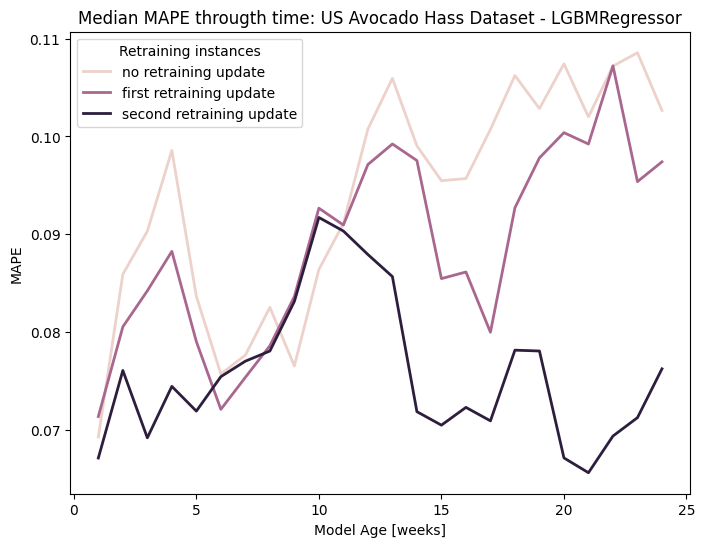

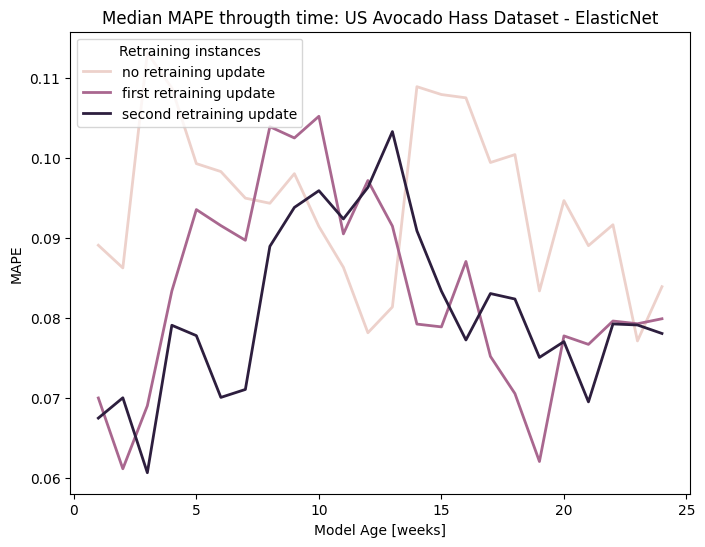

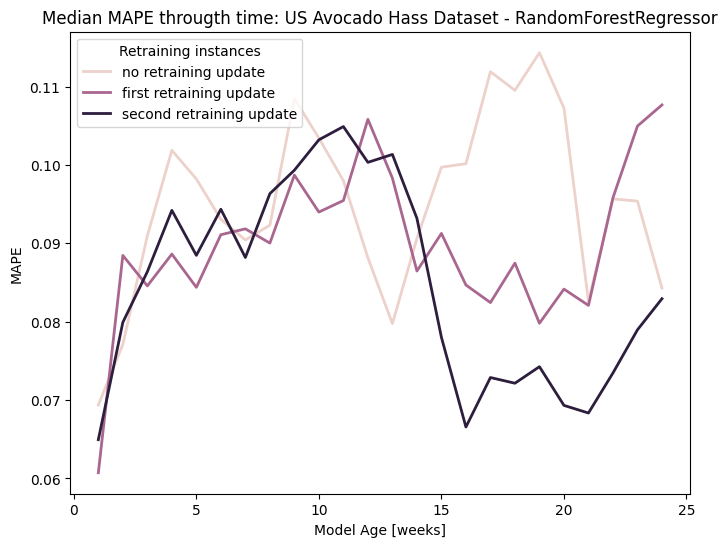

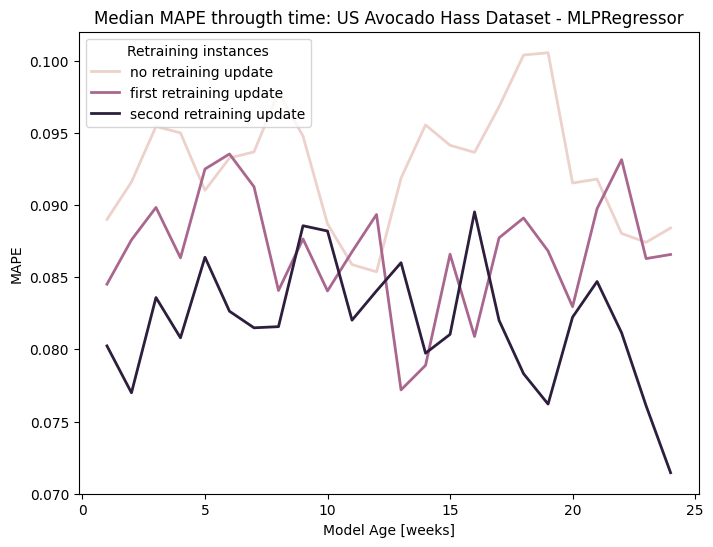

In [4]:
for model in models:


        errors_df = pd.read_parquet(f'../results/retraining/{dataset}/retraining_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod.parquet')
        d_errors_df = pd.read_parquet(f'../results/retraining/{dataset}/retraining_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')

        errors_df = errors_df[errors_df['model_age'] <= 80]
        d_errors_df = d_errors_df[d_errors_df['model_age'] <= 80]
        test_errors_df = errors_df[errors_df['partition'] == 'test']
        test_mape = test_errors_df.groupby('simulation_id').apply(lambda group: mean_absolute_percentage_error(group.y, group.y_pred))
        test_mape = pd.DataFrame(test_mape, columns=['test_mape']).reset_index()

        d_errors_df = pd.merge(d_errors_df, test_mape, how='left', on='simulation_id')
        # d_errors_df = d_errors_df[d_errors_df['test_mape'] <= 0.1]
        
        df = d_errors_df[d_errors_df['partition'] == 'prod']
        df = df.groupby(['partition', 'retraining_id', 'model_age'])['error'].agg(lambda x: x.quantile([0.5])).rename('error').reset_index() 

        fig, ax = plt.subplots(figsize=(8, 6))

        sns.lineplot(data=df, x='model_age', y='error', hue='retraining_id', linewidth=2.0)
        plt.legend(title="Retraining instances",
                labelcolor='linecolor',
                labels=['no retraining update', 'first retraining update','second retraining update'],
                loc="upper left")

        

        plt.xlabel('Model Age [weeks]')
        plt.ylabel('MAPE')
        plt.title(f'Median MAPE througth time: US Avocado Hass Dataset - {model}')

        plt.show()
        fig.savefig(f'../figures/continuous_retraining_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod.svg', format='svg')
